# **02 Model evolution along a *P*–*T*-path**
---

This notebook shows you how to:
1. Model the system evolution of a rock along a predefined *P*–*T*-trajectory, by:
    * Automatically calling repeated Theriak minimisations.
    * Forwarding of bulk rock composition.
2. Visualisation of mineral modes (volume %) and $\Delta G_{excess}$ as a function of *P* and *T*.
3. Start to adapt more complex modelling strategies including porphyroblastic fractionation.\
    *simulating two different behaviors:*
    * Complete inertisation for garnet crystallisation.
    * Inherited resorption upon complete break-down for lawsonite.

**Requirements:**
- python >= 3.10
*with the following packages installed:*
- pytheriak
- matplotlib
- seaborn
- pandas

*Theriak-Domino back-end:*
- A working Theriak-Domino installation.
- theriak.ini file in the working directory.
- Thermodynamic databases to use with Theriak in the working directory.
---

### Import all required libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from pytheriak import wrapper

### Initiate a TherCaller-object.
The argument `programs_dir` must be set to the directory of your Theriak-Domino installation.\
The `database`-file (`"td-ds62-mb50-v07.txt"`) must be in your working directory.

In [2]:
theriak = wrapper.TherCaller(programs_dir="C:\\TheriakDominoWIN\\Programs",
                             database="td-ds62-mb50-v07.txt",
                             theriak_version="v2023.03.06")

### Set model parameter
*P*–*T*-path from Gerya et al. (2002) in Vho et al. Fig. 2 (2020, https://doi.org/10.5194/se-11-307-2020).\
The *P*–*T*-path was digitized using the ***Pathfinder***-module written by Thorsten Markmann (2023, unpubl.).\
\
Bulk rock compositions of metabasalt (MORB) in Vho et al. (2020, https://doi.org/10.5194/se-11-307-2020).\
A small amount of excess oxygen `"O(1)"` is added to account for Fe(III)-bearing endmembers.


In [3]:
pt_path = np.loadtxt(Path("PTpath_Gerya2002.txt")).T
bulk_MORB = "SI(44.78)TI(1.12)AL(15.37)FE(7.74)MN(0.00)MG(10.03)CA(10.83)NA(4.80)K(0.18)H(30.64)O(?)O(1)"

Create lists to store the data we want to track along the *P*–*T*-path.\
In this example we are interested in the modal abundance of lawsonite. Beyond the lawsonite stability field, we track the excess Gibbs free energy of lawsonite.

In [4]:
lawsonite_stable = []
lawsonite_vol_percent = []
lawsonite_dG = []
# to have complete data, store all rocks along PT path
rocks = []

Loop over temperature and pressure pairs in `pt_path`.\
For every *P*–*T*-point `theriak.minimisation()` is called. If lawsonite is stable is checked by looking for `"law"` in `mineral_assemblage`. If lawsonite is stable we save the modal abundance of lawsonite in `lawsonite_vol_percent`. Otherwise we save the excess Gibbs free energy of lawsonite in `lawsonite_dG_excess`.\

This model setup assume complete re-equilibration of the system at every *P*–*T*-point.\

In [5]:
for temperature, pressure in pt_path:
    rock, element_list = theriak.minimisation(pressure, temperature, bulk_MORB, return_failed_minimisation=True)

    # look for lawsonite in the names of the mineral assemblage
    mineral_names = [mineral.name for mineral in rock.mineral_assemblage]
    law_stable = "law" in mineral_names
    # when "law" is in the list of mineral names, it is stable
    lawsonite_stable.append(law_stable)

    # if lawsonite is stable, store its volume percent, delta G is None in that case
    if law_stable:
        law_idx = mineral_names.index("law")
        lawsonite_vol_percent.append(rock.mineral_assemblage[law_idx].vol_percent)
        lawsonite_dG.append(None)
    # if lawsonite is not stable, store its delta G, volume percent is None in that case
    else:
        lawsonite_vol_percent.append(None)
        lawsonite_dG.append(rock.mineral_delta_G["law"])

    rocks.append(rock)

All the data lists, pressure and temperature are combined into a `pd.DataFrame`.

In [6]:
laws_in_MORB = pd.DataFrame({"Temperature": pt_path[:, 0],
                             "Pressure": pt_path[:, 1],
                             "Pressure_kbar": pt_path[:, 1] / 1000,
                             "Lawsonite stable": lawsonite_stable,
                             "Lawsonite vol %": lawsonite_vol_percent,
                             "Lawsonite dG": lawsonite_dG})

A DataFrame allows user-friendly spreadsheet like data visualisation.
Look at the first and last entries with `head()` and `tails()`.

In [7]:
laws_in_MORB.head()

,Temperature,Pressure,Pressure_kbar,Lawsonite stable,Lawsonite vol %,Lawsonite dG
0,350.000,12965.204236,12.965204,True,19.0384,NaN
1,373.625,14417.549168,14.417549,True,19.5503,NaN
2,398.125,15930.408472,15.930408,True,24.9875,NaN
3,420.000,16777.609682,16.777610,True,26.7180,NaN
4,439.250,17534.039334,17.534039,True,26.2032,NaN


In [8]:
laws_in_MORB.tail()

,Temperature,Pressure,Pressure_kbar,Lawsonite stable,Lawsonite vol %,Lawsonite dG
13,619.500,23464.447806,23.464448,False,NaN,986.418
14,640.500,24069.591528,24.069592,False,NaN,1537.670
15,662.375,24765.506808,24.765507,False,NaN,2366.970
16,681.625,25340.393343,25.340393,False,NaN,3157.740
17,700.000,25975.794251,25.975794,False,NaN,3809.070


### Plotting: Modal abundance and excess Gibbs free energy of lawsonite in a *P*–*T*-diagram.

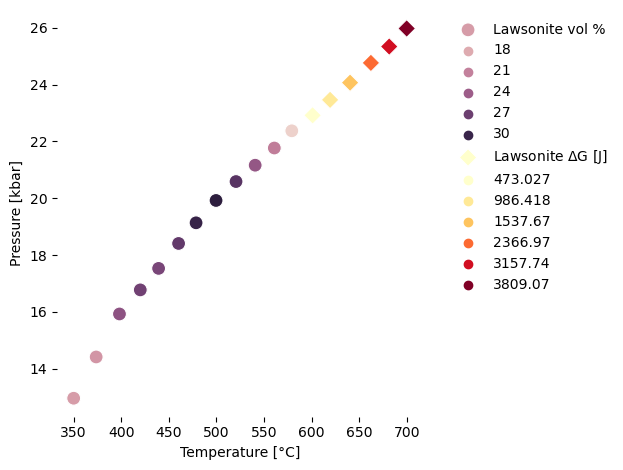

In [22]:
fig, axs = plt.subplots()

sns.scatterplot(data=laws_in_MORB,
                x="Temperature",
                y="Pressure_kbar",
                hue="Lawsonite vol %",
                s=100,
                label="Lawsonite vol %",
                ax=axs)

sns.scatterplot(data=laws_in_MORB,
                x="Temperature",
                y="Pressure_kbar",
                palette="YlOrRd",
                hue="Lawsonite dG",
                s=80,
                marker="D",
                label="Lawsonite $\Delta$G [J]",
                ax=axs)

axs.set_xlabel("Temperature [°C]")
axs.set_ylabel("Pressure [kbar]")

axs.legend(bbox_to_anchor=(1.05, 1), frameon=False)

axs.set_frame_on(False)

fig.tight_layout()

plt.show()

## **Updated modelling strategy: Porphyroblastic fractionation**

However, from the petrography of lawsonite-bearing blueschists and eclogites we now that lawsonite and garnet tend to form big porphyroblasts. Equilibration of such porphyroblasts is known to be potentially kinetically inhibited. By this the elements bound in garnet and lawsonite are effectively removed from the reactive bulk rock composition.\
To account for this in our model we must do some changes to aboves code. After each *P*–*T*-step the elements bound in porphyroblastic garnet and lawsonite should be removed from the bulk to obtain a updated reactive bulk rock composition.\
We want to account for two different behaviors:
1. **Garnet** is assumed to be very robust against resorption and thus effectively inert. All crystallised garnet is non-reversibly removed from the reactive bulk rock composition.
2. **Lawsonite** resorption is assumed to be kinetically inhibited as long as lawsonite is stable in the rock. Upon complete breakdown of lawsonite, all elements bound in lawsonite are added back to the reactive bulk rock composition. This should mimic the observations of euhedral lawsonite porphyroblasts even in pseudomorphic replacements.

To model *Case 2: Lawsonite* at every *P*–*T*-step the stability of lawsonite is checked for a reactive bulk with fractionated and re-equilibrated lawsonite. If lawsonite is predicted stable in either of the two cases, it is treated as fractionated porphyroblast. Only if both cases predict lawsonite to be unstable, the elements bound in lawsonite are added back to the reactive bulk rock composition.

To simulate fractionation of the bulk composition input strings for `theriak.minimisation()` must be modified.\
For this a new function is `bulk_from_compositionalvector` is defined. This function can generate a bulk composition string from a compositional vector (`Rock.bulk_composition_moles`) and the `element_list`.\
For fractionation `Mineral.composition_moles` can then be subtracted from `Rock.bulk_composition_moles`.

In [10]:
def bulk_from_compositionalvector(composition: list | np.ndarray, element_list: list | np.ndarray):
    bulk = ""
    for moles, element in zip(composition, element_list):
        bulk += element
        bulk += "(" + str(moles) + ")"

    return bulk

Create lists to store the data we want to track along the *P*–*T*-path.\

In [11]:
lawsonite_stable_fract = []
lawsonite_restable_fract = []
garnet_stable_fract = []

lawsonite_dG_fract = []

rocks_fract = []

# lists to track reacting volume of system with fractionation
lawsonite_vol_percent_fract = [0]
garnet_vol_percent_fract = [0]
reactive_vol_fract = [1]

# these arrays take care of the absolute moles for fractionation calculations
# initialize with 0
lawsonite_moles = np.array([np.zeros(len(element_list))])
garnet_moles = np.array([np.zeros(len(element_list))])
# initialize with the bulk composition of MORB
reactive_bulk_moles = np.array([rocks[0].bulk_composition_moles])

In [12]:
for temperature, pressure in pt_path:
    input_bulk = bulk_from_compositionalvector(reactive_bulk_moles[-1], element_list)

    rock, element_list = theriak.minimisation(pressure, temperature, input_bulk, return_failed_minimisation=True)

    # look for lawsonite in the names of the mineral assemblage
    mineral_names = [mineral.name for mineral in rock.mineral_assemblage]
    law_stable = "law" in mineral_names

    if not law_stable:
        # change the input (reactive) bulk to include lawsonite
        input_bulk = bulk_from_compositionalvector(reactive_bulk_moles[-1] + lawsonite_moles[-1], element_list)
        rock_incl_law, element_list = theriak.minimisation(pressure, temperature, input_bulk, return_failed_minimisation=True)

        # look for lawsonite in the names of the mineral assemblage
        mineral_names_incl_law = [mineral.name for mineral in rock_incl_law.mineral_assemblage]
        law_restable = "law" in mineral_names_incl_law

        if law_restable:

            print(f"Lawsonite, got restabilised at {temperature:.0f} °C and {pressure:.0f} bar".format(temperature, pressure))

        else:
            rock = rock_incl_law
            mineral_names = mineral_names_incl_law
            reactive_bulk_moles[-1] += lawsonite_moles[-1]

        lawsonite_stable_fract.append(law_restable)

    else:
        lawsonite_stable_fract.append(law_stable)

    # look for garnet in the names of the mineral assemblage
    # all possible solutions (all starting with "GRT_") must be checked
    garnet_stable = len([mineral for mineral in mineral_names if mineral.startswith("GRT_")]) > 0
    # when "GRT_" is in the list of mineral names, it is stable
    garnet_stable_fract.append(garnet_stable)

    # append data of interest to lists
    if garnet_stable:
        garnet_idx = mineral_names.index([mineral for mineral in mineral_names if mineral.startswith("GRT_")][0])
        garnet_vol_percent = rock.mineral_assemblage[garnet_idx].vol_percent
        # correct for fraction of reacting volume
        garnet_vol_percent = garnet_vol_percent * reactive_vol_fract[-1]
        garnet_vol_percent_fract.append(garnet_vol_percent_fract[-1] + garnet_vol_percent)

        # add the moles of garnet to the array
        new_garnet_moles = rock.mineral_assemblage[garnet_idx].composition_moles
        garnet_moles = np.append(garnet_moles, [new_garnet_moles], axis=0)

    else:
        garnet_vol_percent = 0
        garnet_vol_percent_fract.append(garnet_vol_percent_fract[-1])

        garnet_moles = np.append(garnet_moles, [np.zeros(len(element_list))], axis=0)


    if law_stable:
        law_idx = mineral_names.index("law")
        law_vol_percent = rock.mineral_assemblage[law_idx].vol_percent

        # correct for fraction of reacting volume
        law_vol_percent = law_vol_percent * reactive_vol_fract[-1]
        lawsonite_vol_percent_fract.append(lawsonite_vol_percent_fract[-1] + law_vol_percent)

        # add the moles of lawsonite to the array
        new_lawsonite_moles = rock.mineral_assemblage[law_idx].composition_moles

        lawsonite_moles = np.append(lawsonite_moles, [new_lawsonite_moles], axis=0)

        lawsonite_dG_fract.append(None)

    else:
        if law_restable:
            lawsonite_vol_percent_fract.append(lawsonite_vol_percent_fract[-1])
        else:
            lawsonite_vol_percent_fract.append(None)

        lawsonite_moles = np.append(lawsonite_moles, [np.zeros(len(element_list))], axis=0)

        lawsonite_dG_fract.append(rock.mineral_delta_G["law"])

    # update reactive volume
    reactive_vol_fract.append(reactive_vol_fract[-1] - law_vol_percent/100 - garnet_vol_percent/100)

    # fractionate the bulk composition
    reactive_bulk_moles = np.append(reactive_bulk_moles, [reactive_bulk_moles[-1] - lawsonite_moles[-1] - garnet_moles[-1]], axis=0)

Lawsonite, got restabilised at 439 °C and 17534 bar


In [13]:
laws_in_MORB_fract = pd.DataFrame({"Temperature": pt_path[:, 0],
                                   "Pressure": pt_path[:, 1],
                                   "Pressure_kbar": pt_path[:, 1] / 1000,
                                   "Lawsonite stable": lawsonite_stable_fract,
                                   "Lawsonite vol %": lawsonite_vol_percent_fract[1:],
                                   "Lawsonite dG": lawsonite_dG_fract,
                                   "Garnet stable": garnet_stable_fract,
                                   "Garnet vol %": garnet_vol_percent_fract[1:]})

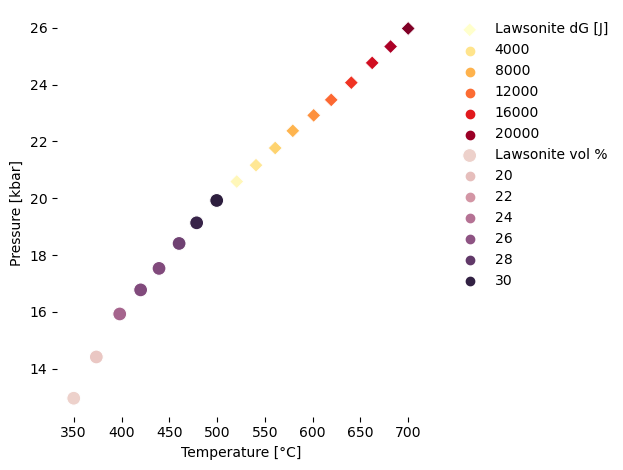

In [14]:
fig, axs = plt.subplots()

sns.scatterplot(data=laws_in_MORB_fract,
                x="Temperature",
                y="Pressure_kbar",
                palette="YlOrRd",
                hue="Lawsonite dG",
                s=50,
                marker="D",
                label="Lawsonite dG [J]",
                ax=axs)

sns.scatterplot(data=laws_in_MORB_fract,
                x="Temperature",
                y="Pressure_kbar",
                hue="Lawsonite vol %",
                s=100,
                label="Lawsonite vol %",
                ax=axs)

axs.set_xlabel("Temperature [°C]")
axs.set_ylabel("Pressure [kbar]")

axs.legend(bbox_to_anchor=(1.05, 1), frameon=False)

axs.set_frame_on(False)

fig.tight_layout()

plt.show()

### Plotting: Mineral volume along P-T-path

In [15]:
COLOR_GARNET = "#900C3F"
COLOR_LAWSONITE = "#6c97d4"
COLOR_LAWSONITE_FRAC = "#2e0e8f"

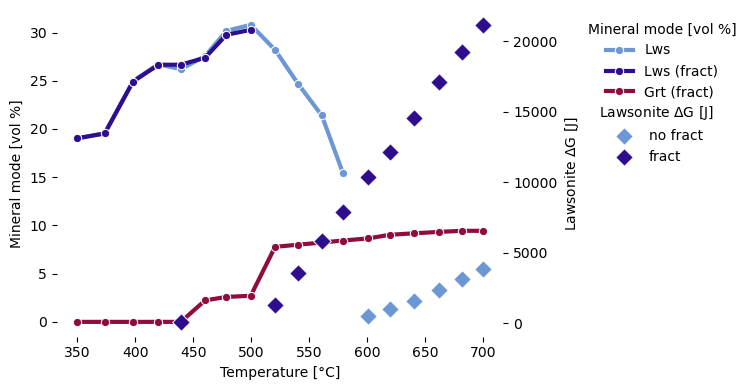

In [19]:
fig, axs = plt.subplots(figsize=(9, 4))

sns.lineplot(data=laws_in_MORB,
             x="Temperature",
             y="Lawsonite vol %",
             c=COLOR_LAWSONITE,
             lw=3,
             marker="o",
             label="Lws",)

sns.lineplot(data=laws_in_MORB_fract,
             x="Temperature",
             y="Lawsonite vol %",
             c=COLOR_LAWSONITE_FRAC,
             lw=3,
             marker="o",
             label="Lws (fract)")

sns.lineplot(data=laws_in_MORB_fract,
             x="Temperature",
             y="Garnet vol %",
             c=COLOR_GARNET,
             lw=3,
             marker="o",
             label="Grt (fract)")

axs2 = plt.twinx(axs)

sns.scatterplot(data=laws_in_MORB,
             x="Temperature",
             y="Lawsonite dG",
             c=COLOR_LAWSONITE,
             marker="D",
             s=80,
             label="no fract",
             ax=axs2)

sns.scatterplot(data=laws_in_MORB_fract,
             x="Temperature",
             y="Lawsonite dG",
             c=COLOR_LAWSONITE_FRAC,
             marker="D",
             s=80,
             label="fract",
             ax=axs2)

axs.set_xlabel("Temperature [°C]")
axs.set_ylabel("Mineral mode [vol %]")
axs2.set_ylabel(r"Lawsonite $\Delta$G [J]")

axs.legend(title="Mineral mode [vol %]", bbox_to_anchor=(1.55, 1), frameon=False)
axs2.legend(title=r"Lawsonite $\Delta$G [J]", bbox_to_anchor=(1.5, 0.75), frameon=False)

axs.set_frame_on(False)
axs2.set_frame_on(False)

fig.tight_layout()

plt.show()